<a href="https://colab.research.google.com/github/dmitriygorlov/Yandex.Practikum_Data_Science/blob/main/Module-01_03-Statistical-analysis-of-data/project-3_cellular-company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение перспективного тарифа для телеком компании
Надо сделать предварительный анализ тарифов на небольшой выборке клиентов. Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# План исследования:
1. Первичное прочтение данных
Загрузка библиотек и таблиц
2. Предобработка
Изменение типов данных, обработка на ошибки, дубликаты и пропуски; расчёт и добавление необходимых столбцов
3. Анализ данных
Описание данных, построение графиков.
4. Проверка гипотез
Нулевые и альтернативные гипотезы
5. Общий вывод

## Первичное прочтение данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')

tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')

Импортируем библиотеки и читаем файлы. Учитывая, что файлов несколько, скорее всего задействуем объединение данных, нужно быть внимательным к столбцам/ключам.

## Предобработка

### Изменение типов данных, обработка на ошибки, дубликаты и пропуски

In [2]:
users.info()
print(users.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
   user_id  age churn_date  ...  last_name    reg_date tariff
0     1000   52        NaN  ...  Верещагин  2018-05-25  ultra
1     1001   41        NaN  ...       Ежов  2018-11-01  smart
2     1002   59        NaN  ...  Абрамович  2018-06-17  smart
3     1003   23        NaN  ...   Белякова  2018-08-17  ultra
4     1004   68        NaN  ...   Авдеенко  2018-05-14  ultra

[5 rows x 8 columns]


В таблице 'users' хранится основная информация по пользователям, разбитые по строкам. Есть столбец ID для связки с другими таблицами, выбранный тариф и начало регистрации, конец регистрации (всего лишь 38 значений/окончившихся тарифов) и описывающие клиента атрибуты: возраст, город, Имя, Фамилия. Пустых значений нет кроме окончания даты, проверим только на дубликаты ID и тарифы + регионы на унификацию, а также изменим тип данных у дат (churn_date, reg_date)

In [3]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format= '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format= '%Y-%m-%d')

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Тип данных для даты был изменен, остальные подходят

In [4]:
print(users.duplicated('user_id').sum())
print()
print(users['tariff'].value_counts())
print()
print(users['city'].value_counts())

0

smart    351
ultra    149
Name: tariff, dtype: int64

Москва             99
Санкт-Петербург    39
Новосибирск        16
Казань             14
Омск               14
                   ..
Архангельск         1
Нижневартовск       1
Химки               1
Подольск            1
Иваново             1
Name: city, Length: 76, dtype: int64


Дубликатов в ID нет.

В тарифах всё унифицировано, смарт больше, чем ультра, других значений нет.

В городах есть лидирующая Москва с 99 строк и другие объекты, странных значений не заметно.

In [5]:
calls.info()
print(calls.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000


В таблице 'Calls' хранится информация о звонках и таблица ОЧЕНь большая и лучше использовать из неё срезы :). В столбцах есть id (сам id уникального звонка), call_date (дата звонка), duration (продолжительность звонка нечётным числом) и users_id (ключ к таблице пользователей). Пустых объектов строк нет, но нужно изменить тип данных для даты, решить ситуацию с нулевыми звонками, а также округлить продолжительность звонков в большую сторону.

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Заменили тип данных для даты звонка. Оценим масштаб проблемы с нулевым звонками

In [7]:
print(len(calls[calls['duration'] == 0])/len(calls))

0.19551644316336553


Почтb 20% - это нулевые звонки. Исходя из логики - это, вероятно, исходящие звонки, на которые не было ответа. Учитывая, что нас интересует финансовая часть звонков (а не например техническая для нагрузки на базу), то уберём их как неинтересные нам и как те, кто может сбить среднее и другую статистику. **Убираем нулевые звонки ввиду их неинтересности для финансового изучения, а также их влияния на среднее, количество и тд**

In [8]:
print(len(calls))
calls = calls[calls['duration'] != 0]
print(len(calls))

202607
162994


Нулевые звонки убраны из базы звонков, обратим внимание на округление вверх

In [9]:
calls['duration'] = np.ceil(calls['duration']).astype(int)
print(calls.head())
calls.info()

       id  call_date  duration  user_id
2  1000_2 2018-06-11         3     1000
3  1000_3 2018-09-21        14     1000
4  1000_4 2018-12-15         6     1000
7  1000_7 2018-08-22        19     1000
8  1000_8 2018-09-15        19     1000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         162994 non-null  object        
 1   call_date  162994 non-null  datetime64[ns]
 2   duration   162994 non-null  int64         
 3   user_id    162994 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


Округлили вверх с помощью функции из numpy и превращаем в целочисленный тип (нули после запятой становятся не нужны)

In [10]:
internet.info()
print(internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000


В таблице 'internet' хранится информация об интернет сессиях пользователей и таблица тоже весьма большая и нужно использовать срезы :). в таблице есть id (id сессии), mb_used (количество использованного трафика в сессии), session_date (дата сессии),  user_id (ключ к основной таблице пользователей). Пустых значений нет, есть странный столбец Unnamed (нужно понять есть ли в нём смысл), нужно изменить тип данных у даты, а также округлить мегабайты.

In [11]:
internet.set_axis(['unnamed', 'id', 'mb_used', 'session_date', 'user_id'], axis = 'columns', inplace=True)
internet.info()
print(internet['unnamed'].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   unnamed       149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
Name: unnamed, dtype: int64


Столбец дублирует индекс и судя по всему (и по гуглению) возник из несоответсвтия прочтения файла. е будем перечитывать файл, удалим столбец.

In [12]:
internet.drop('unnamed', axis=1, inplace=True)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Столбец удален, поменяем дату

In [13]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Дата изменена, округлим и поменяем тип у мегабайтов и заодно проверим на нули (возможна ситуация с "неудавшимися" сеансами)

In [14]:
internet['mb_used'] = np.ceil(internet['mb_used']).astype(int)
internet.info()
print(internet.head())
print()
print(len(internet[internet['mb_used'] == 0])/len(internet))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int64         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB
       id  mb_used session_date  user_id
0  1000_0      113   2018-11-25     1000
1  1000_1     1053   2018-09-07     1000
2  1000_2     1198   2018-06-25     1000
3  1000_3      551   2018-08-22     1000
4  1000_4      303   2018-09-24     1000

0.13118155773916304


Округление и изменение типа данных провели успешно, но у 13% найдено нулевые значения. **Удалим сессии с нулевыми мегабайтами также по причине изучения финансовой части и скошенности данных** 

In [15]:
print(len(internet))
internet = internet[internet['mb_used'] != 0]
print(len(internet))

149396
129798


Нулевые значения убрали и переходим к следующей таблице

In [16]:
messages.info()
print(messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000


Таблица 'messages' состоит из информации по отправленным сообщениям по пользователем и также большая и лучше снимать информацию срезами. Таблица состоит из id (уникальный id сообщения), message_date (даты сообщения), user_id (ключ к общей таблицы по пользователям). Пустых значений нет, а также нет и "числительных" значений (строчка = 1 сообение), поэтому нужно только поменять тип данных у даты.

In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Тип данных изменен, переходим к последней таблице тарифы

In [18]:
tariffs.info()
print(tariffs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
   messages_included  mb_per_month_included  ...  rub_per_minute  tariff_name
0                 50                  15360  ...               3        smart
1               1000                  30720  ...               1        ultra

[2 rows x 8 columns]


В таблице 'tariffs' всего 2 строчки: указана информация, что за тариф (tariff_name), а также все лимиты, стоимость абонентская и цены свыше лимитов. Предобработка не нужна, все в нужных форматах

### Расчёт и добавление необходимых столбцов

Учитывая объёмы таблиц будем делать группировки в таблицах сообщений, звонков и интернета, а затем добавлять информацию в основную таблицу, сочетая по user_id.

После этого посчитаем финансовые показатели

Начнём с звонков

In [19]:
print(calls.head(5))
calls['month'] = calls['call_date'].dt.month
calls_group = calls.pivot_table (
    index = ['user_id', 'month'], 
    values = 'duration', 
    aggfunc = ('count', 'sum')
).reset_index()
calls_group.set_axis(['user_id', 'month', 'min_count', 'min_sum'], axis = 'columns', inplace=True)
print(calls_group.head(5))


       id  call_date  duration  user_id
2  1000_2 2018-06-11         3     1000
3  1000_3 2018-09-21        14     1000
4  1000_4 2018-12-15         6     1000
7  1000_7 2018-08-22        19     1000
8  1000_8 2018-09-15        19     1000
   user_id  month  min_count  min_sum
0     1000      5         17      159
1     1000      6         28      172
2     1000      7         41      340
3     1000      8         42      408
4     1000      9         46      466


Теперь у нас есть таблица 'calls_group' с информацией по пользователям и месяцам с количеством звонков и суммой.

In [20]:
print(messages.head(5))
messages['month'] = messages['message_date'].dt.month
messages_group = messages.pivot_table (
    index = ['user_id', 'month'], 
    values = 'id', 
    aggfunc = ('count')
).reset_index()
messages_group.set_axis(['user_id', 'month', 'mes_count'], axis = 'columns', inplace=True)
print(messages_group.head(5))

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
   user_id  month  mes_count
0     1000      5         22
1     1000      6         60
2     1000      7         75
3     1000      8         81
4     1000      9         57


Теперь у нас есть таблица 'messages_group' с информацией по пользователям и месяцам с количеством сообщений. Сделаем общую таблицу со звонками.

In [21]:
print('calls_group', len(calls_group))
print('messages_group', len(messages_group))

calls_messages_group = pd.merge(calls_group, messages_group, on = ['user_id', 'month'], how = 'outer').fillna(0)

print('calls_messages_group', len(calls_messages_group))

calls_messages_group['min_count'] = calls_messages_group['min_count'].astype(int)
calls_messages_group['min_sum'] = calls_messages_group['min_sum'].astype(int)
calls_messages_group['mes_count'] = calls_messages_group['mes_count'].astype(int)

calls_messages_group.info()
print(calls_messages_group.head())

calls_group 3168
messages_group 2717
calls_messages_group 3212
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3212 entries, 0 to 3211
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    3212 non-null   int64
 1   month      3212 non-null   int64
 2   min_count  3212 non-null   int64
 3   min_sum    3212 non-null   int64
 4   mes_count  3212 non-null   int64
dtypes: int64(5)
memory usage: 150.6 KB
   user_id  month  min_count  min_sum  mes_count
0     1000      5         17      159         22
1     1000      6         28      172         60
2     1000      7         41      340         75
3     1000      8         42      408         81
4     1000      9         46      466         57


Объединили таблицы со всеми значениями, заполнили пустые значения нулями (не было событий в этот месяц по данному параметру), поменяли типы данных на целые, получим сгруппированную таблицу интернет

In [22]:
print(internet.head(5))
internet['month'] = internet['session_date'].dt.month
internet_group = internet.pivot_table (
    index = ['user_id', 'month'], 
    values = 'mb_used', 
    aggfunc = ('sum')
).reset_index()
internet_group.set_axis(['user_id', 'month', 'mb_sum'], axis = 'columns', inplace=True)
print(internet_group.head(5))

       id  mb_used session_date  user_id
0  1000_0      113   2018-11-25     1000
1  1000_1     1053   2018-09-07     1000
2  1000_2     1198   2018-06-25     1000
3  1000_3      551   2018-08-22     1000
4  1000_4      303   2018-09-24     1000
   user_id  month  mb_sum
0     1000      5    2256
1     1000      6   23257
2     1000      7   14016
3     1000      8   14070
4     1000      9   14581


Теперь у нас есть таблица 'internet_group' с объёмом израсходанного трафика, объединим со звонками и сообщениями

In [23]:
calls_messages_internet_group = pd.merge(calls_messages_group, internet_group, on = ['user_id', 'month'], how = 'outer').fillna(0)

calls_messages_internet_group['min_count'] = calls_messages_internet_group['min_count'].astype(int)
calls_messages_internet_group['min_sum'] = calls_messages_internet_group['min_sum'].astype(int)
calls_messages_internet_group['mes_count'] = calls_messages_internet_group['mes_count'].astype(int)
calls_messages_internet_group['mb_sum'] = calls_messages_internet_group['mb_sum'].astype(int)

calls_messages_internet_group.info()
print(calls_messages_internet_group.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    3214 non-null   int64
 1   month      3214 non-null   int64
 2   min_count  3214 non-null   int64
 3   min_sum    3214 non-null   int64
 4   mes_count  3214 non-null   int64
 5   mb_sum     3214 non-null   int64
dtypes: int64(6)
memory usage: 175.8 KB
   user_id  month  min_count  min_sum  mes_count  mb_sum
0     1000      5         17      159         22    2256
1     1000      6         28      172         60   23257
2     1000      7         41      340         75   14016
3     1000      8         42      408         81   14070
4     1000      9         46      466         57   14581


Теперь получена общая таблица 'calls_messages_internet_group' с данными по интернету, звонкам и сообщениям. Добавим информацию по пользователям, которую предварительно объединим с тарифами

In [24]:
print(tariffs.columns.values)
print()
print(users.columns.values)
users.set_axis(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name'], axis=1, inplace=True)

users_tarrifs = pd.merge(users, tariffs, on = 'tariff_name') #how не нужен

#назовём общую таблицу data для простоты

data = pd.merge(calls_messages_internet_group, users_tarrifs, how = 'outer')

data.info()
print(data.head())

['messages_included' 'mb_per_month_included' 'minutes_included'
 'rub_monthly_fee' 'rub_per_gb' 'rub_per_message' 'rub_per_minute'
 'tariff_name']

['user_id' 'age' 'churn_date' 'city' 'first_name' 'last_name' 'reg_date'
 'tariff']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   min_count              3214 non-null   float64       
 3   min_sum                3214 non-null   float64       
 4   mes_count              3214 non-null   float64       
 5   mb_sum                 3214 non-null   float64       
 6   age                    3216 non-null   int64         
 7   churn_date             189 non-null    datetime64[ns]
 8   city                   3216 non-null   object        
 9   first_n

ПОлучили общую таблицу data. При объединении значения по интернету, звонкам и сообщениям изменилось на тип float, значит есть пустые значения, остальные данные подгрузились корректно. Это значит, что **есть пользователи, по которым нет данных по звонкам, сообщениям и интернету (не пользовались услугами, но всё равно нужно посчитать им абонентскую плату)** Учтём это при дальнейших расчётах, пока заполним нулями значения и поменяем тип на целочисленный (у пользователей без всего заполним нулями месяца)

In [25]:
data = data.fillna(0)

data['min_count'] = data['min_count'].astype(int)
data['min_sum'] = data['min_sum'].astype(int)
data['mes_count'] = data['mes_count'].astype(int)
data['mb_sum'] = data['mb_sum'].astype(int)

data['month'] = data['month'].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3216 non-null   int64         
 2   min_count              3216 non-null   int64         
 3   min_sum                3216 non-null   int64         
 4   mes_count              3216 non-null   int64         
 5   mb_sum                 3216 non-null   int64         
 6   age                    3216 non-null   int64         
 7   churn_date             3216 non-null   object        
 8   city                   3216 non-null   object        
 9   first_name             3216 non-null   object        
 10  last_name              3216 non-null   object        
 11  reg_date               3216 non-null   datetime64[ns]
 12  tariff_name            3216 non-null   object        
 13  mes

Сделаем функцию для расчёта денег

In [26]:
def rub_tot(row):
    
    minutes = row['min_sum']
    min_incl = row['minutes_included']
    rub_per_minute = row['rub_per_minute']
    
    messages = row['mes_count']
    mes_incl = row['messages_included']
    rub_per_message = row['rub_per_message']
    
    trafic = row['mb_sum']
    mb_incl = row['mb_per_month_included'] 
    rub_per_gb = row['rub_per_gb']
    
    rub_fee = row['rub_monthly_fee']
            
    min_over = minutes - min_incl
    if min_over > 0:
        rub_min = min_over * rub_per_minute
    else:
        rub_min = 0

        
    mes_over = messages - mes_incl
    if mes_over > 0:
        rub_mes = mes_over * rub_per_message
    else:
        rub_mes = 0

    gb_over = np.ceil((trafic - mb_incl)/1024)
    if gb_over > 0:
        rub_gb = gb_over * rub_per_gb
    else:
        rub_gb = 0
            
            
    rub_total = rub_min + rub_mes + rub_gb + rub_fee
    
    return rub_total

In [27]:
data['rub_totally'] = data.apply(rub_tot, axis = 1)

Данные по финансам получены, сделаем разбивку по разным тарифам для дальнейшего удобства

In [28]:
data_smart = data[data['tariff_name'] == 'smart']
data_ultra = data[data['tariff_name'] == 'ultra']

Теперь у нас есть все необходимые финансовые данные, проведена вся предобработка и перейдём к анализу

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### Общее

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3216 non-null   int64         
 2   min_count              3216 non-null   int64         
 3   min_sum                3216 non-null   int64         
 4   mes_count              3216 non-null   int64         
 5   mb_sum                 3216 non-null   int64         
 6   age                    3216 non-null   int64         
 7   churn_date             3216 non-null   object        
 8   city                   3216 non-null   object        
 9   first_name             3216 non-null   object        
 10  last_name              3216 non-null   object        
 11  reg_date               3216 non-null   datetime64[ns]
 12  tariff_name            3216 non-null   object        
 13  mes

In [30]:
print('Пользователям тарифа Smart в месяц нужно:')
print('{:.0f} звонков'.format(data_smart['min_count'].mean()))
print('{:.0f} минут в среднем'.format(data_smart['min_sum'].mean()))
print('{:.0f} сообщений в среднем'.format(data_smart['mes_count'].mean()))
print('{:.2f} гигабайт в среднем'.format(data_smart['mb_sum'].mean()/ 1024))
print()
print('Пользователям тарифа Ultra в месяц нужно:')
print('{:.0f} звонков'.format(data_ultra['min_count'].mean()))
print('{:.0f} минут в среднем'.format(data_ultra['min_sum'].mean()))
print('{:.0f} сообщений в среднем'.format(data_ultra['mes_count'].mean()))
print('{:.2f} гигабайт в среднем'.format(data_ultra['mb_sum'].mean()/ 1024))


Пользователям тарифа Smart в месяц нужно:
47 звонков
418 минут в среднем
33 сообщений в среднем
15.84 гигабайт в среднем

Пользователям тарифа Ultra в месяц нужно:
59 звонков
526 минут в среднем
49 сообщений в среднем
19.01 гигабайт в среднем


В целом пользователи Ultra больше, чем пользователи Smart звонят, пишут сообщений и тратят интернет трафика. 

При этом пользователи Smart в среднем укладываются в границы своего тарифа по звонкам и сообщениям, но не интернета (Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика), а пользователи Ultra точно укладываются в свой большой тариф (Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика).

Рассмотрим каждый показатель подробнее

### Минуты

Статистика по минутам для Smart
Среднее количество минут: 418
Стандартное отклонение: 190
Дисперсия: 36265


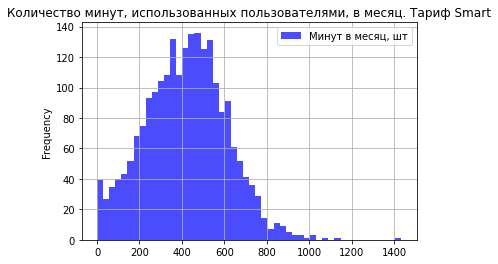


Статистика по минутам для Ultra
Среднее количество минут: 526
Стандартное отклонение: 318
Дисперсия: 100950


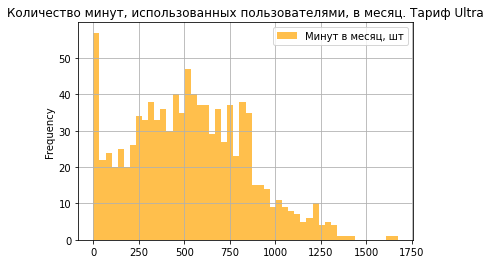

In [31]:
print('Статистика по минутам для Smart')
print('Среднее количество минут: {:.0f}'.format(data_smart['min_sum'].mean()))
print('Стандартное отклонение: {:.0f}'.format(data_smart['min_sum'].std()))
print('Дисперсия: {:.0f}'.format(np.var(data_smart['min_sum'])))
data_smart.plot(kind='hist',
    y='min_sum',
    title = 'Количество минут, использованных пользователями, в месяц. Тариф Smart',
    bins=50,
    alpha=0.7,
    label='Минут в месяц, шт',
    color='blue',
    grid=True,
    legend=True
               )
plt.show()
print()
print('Статистика по минутам для Ultra')
print('Среднее количество минут: {:.0f}'.format(data_ultra['min_sum'].mean()))
print('Стандартное отклонение: {:.0f}'.format(data_ultra['min_sum'].std()))
print('Дисперсия: {:.0f}'.format(np.var(data_ultra['min_sum'])))
data_ultra.plot(kind='hist',
    y='min_sum',
    title = 'Количество минут, использованных пользователями, в месяц. Тариф Ultra',
    bins=50,
    alpha=0.7,
    label='Минут в месяц, шт',
    color='orange',
    grid=True,
    legend=True
               )
plt.show()

# data_smart['min_sum'].hist(bins = 100, alpha = 0.7)
# data_ultra['min_sum'].hist(bins = 100, alpha = 0.7)

Пользователи тарифа Smart:
- спределение схоже с нормальным, отрицательная скошенность
- среднее значение 418 минут
- стандартное отклонение 190
- дисперсия 36265
- есть немного нулевых значений 
- почти нет значений после 1000
- достаточно много значений свыше 500 (сколько входит в абонентскую плату), 


Пользователи тарифа Ultra: 
- распределение схожее с нормальным, положительная скошенность
- среднее значение 526
- стандартное отклонение 318
- дисперсия 100950. 
- есть много нулевых значений (возможно пользуются тарифом не для звонков) 
- почти нет значений после 1400
- все значения значительно ниже 3000 (сколько входит в абонентскую плату), 


### Сообщения

Статистика по сообщениям для Smart
Среднее количество сообщений: 33
Стандартное отклонение: 28
Дисперсия: 797


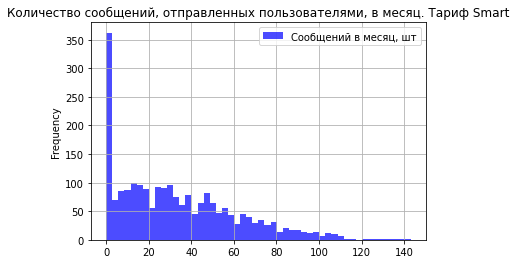


Статистика по сообщениям для Ultra
Среднее количество сообщений: 49
Стандартное отклонение: 48
Дисперсия: 2283


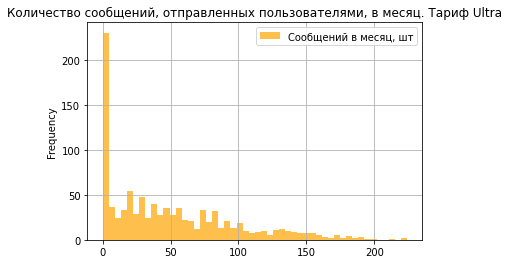

In [32]:
print('Статистика по сообщениям для Smart')
print('Среднее количество сообщений: {:.0f}'.format(data_smart['mes_count'].mean()))
print('Стандартное отклонение: {:.0f}'.format(data_smart['mes_count'].std()))
print('Дисперсия: {:.0f}'.format(np.var(data_smart['mes_count'])))
data_smart.plot(kind='hist',
    y='mes_count',
    title = 'Количество сообщений, отправленных пользователями, в месяц. Тариф Smart',
    bins=50,
    alpha=0.7,
    label='Сообщений в месяц, шт',
    color='blue',
    grid=True,
    legend=True
               )
plt.show()
print()
print('Статистика по сообщениям для Ultra')
print('Среднее количество сообщений: {:.0f}'.format(data_ultra['mes_count'].mean()))
print('Стандартное отклонение: {:.0f}'.format(data_ultra['mes_count'].std()))
print('Дисперсия: {:.0f}'.format(np.var(data_ultra['mes_count'])))
data_ultra.plot(kind='hist',
    y='mes_count',
    title = 'Количество сообщений, отправленных пользователями, в месяц. Тариф Ultra',
    bins=50,
    alpha=0.7,
    label='Сообщений в месяц, шт',
    color='orange',
    grid=True,
    legend=True
               )
plt.show()


# data_smart['mes_count'].hist(bins = 50, alpha = 0.7)
# data_ultra['mes_count'].hist(bins = 50, alpha = 0.7)



Пользователи тарифа Smart:
- спределение схоже с нормальным, положительная скошенность
- среднее значение 33 сообщения
- стандартное отклонение 28
- дисперсия 797
- есть много нулевых значений (кажется сообщениями многие не пользуются)
- почти нет значений после 120
- достаточно много значений свыше 50 (сколько входит в абонентскую плату), 


Пользователи тарифа Ultra: 
- распределение схожее с нормальным, положительная скошенность
- среднее значение 49 сообщений
- стандартное отклонение 48
- дисперсия 2283
- есть много нулевых значений (кажется сообщениями многие не пользуются)
- почти нет значений после 200
- все значения значительно ниже 1000 (сколько входит в абонентскую плату), 


### Интернет

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Статистика по интернет трафику для Smart
Среднее количество мегабайт: 15.8
Стандартное отклонение: 5.7
Дисперсия: 33


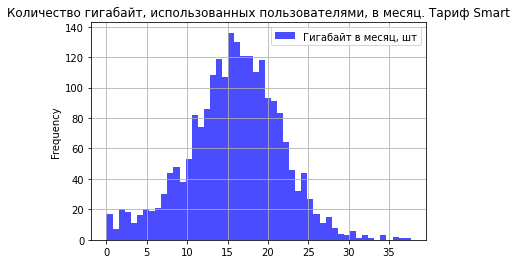


Статистика по интернет трафику для Ultra
Среднее количество мегабайт: 19.0
Стандартное отклонение: 9.9
Дисперсия: 97


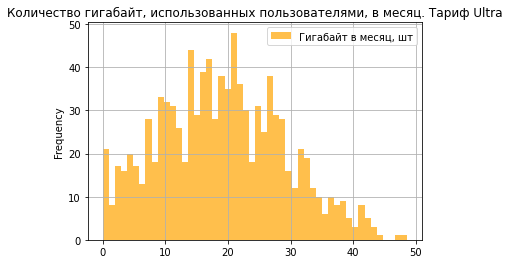

In [33]:
data_smart['gb_sum'] = data_smart['mb_sum'] / 1024
data_ultra['gb_sum'] = data_ultra['mb_sum'] / 1024

print('Статистика по интернет трафику для Smart')
print('Среднее количество мегабайт: {:.1f}'.format(data_smart['gb_sum'].mean()))
print('Стандартное отклонение: {:.1f}'.format(data_smart['gb_sum'].std()))
print('Дисперсия: {:.0f}'.format(np.var(data_smart['gb_sum'])))
data_smart.plot(kind='hist',
    y='gb_sum',
    title = 'Количество гигабайт, использованных пользователями, в месяц. Тариф Smart',
    bins=50,
    alpha=0.7,
    label='Гигабайт в месяц, шт',
    color='blue',
    grid=True,
    legend=True
               )
plt.show()
print()
print('Статистика по интернет трафику для Ultra')
print('Среднее количество мегабайт: {:.1f}'.format(data_ultra['gb_sum'].mean()))
print('Стандартное отклонение: {:.1f}'.format(data_ultra['gb_sum'].std()))
print('Дисперсия: {:.0f}'.format(np.var(data_ultra['gb_sum'])))
data_ultra.plot(kind='hist',
    y='gb_sum',
    title = 'Количество гигабайт, использованных пользователями, в месяц. Тариф Ultra',
    bins=50,
    alpha=0.7,
    label='Гигабайт в месяц, шт',
    color='orange',
    grid=True,
    legend=True
               )
plt.show()
# data_smart['gb_sum'].hist(bins = 100, alpha = 0.7)
# data_ultra['gb_sum'].hist(bins = 100, alpha = 0.7)

Пользователи тарифа Smart:
- спределение схоже с нормальным
- среднее значение 15,8 гигабайт
- стандартное отклонение 5,7
- дисперсия 33
- почти нет нулевых значений
- почти нет значений после 33 гб
- достаточно много значений свыше 15 гб (сколько входит в абонентскую плату), 


Пользователи тарифа Ultra: 
- распределение схожее с нормальным, положительная скошенность
- среднее значение 19 гигабайт
- стандартное отклонение 9,9
- дисперсия 97 
- нулевых значений среднее количество
- почти нет значений после 45 гб
- достаточно много значений свыше 30 гб (сколько входит в абонентскую плату), 

## Проверка гипотез

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Выборка пользователей разных тарифов не является зависимой (никто не наступает после друг друга), будем сравнивать как две независимые совокупности.

Нулевая гипотеза должна быть о равенстве, поэтому она будет "средняя выручка пользователей тарифов «Ультра» и «Смарт» равна". Нам не важно (для вопроса) о том, как различается выручка в большую или меньшую сторону поэтому альтернативная гипотеза будет двусторонней, а именно "средняя выручка пользователей различается"

In [34]:
# data.info()

alpha = 0.05

first_results = st.ttest_ind(data_smart['rub_totally'], data_ultra['rub_totally'], equal_var = False)

if first_results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, потому что p={:.2f}'.format(first_results.pvalue))
else:
    print('Не отвергаем нулевую гипотезу, потому что p={:.2f}'.format(first_results.pvalue))

print()    
print('Средняя выручка пользователя тарифа Smart: {:.2f}'.format(data_smart['rub_totally'].mean()))
print()
print('Средняя выручка пользователя тарифа Ultra: {:.2f}'.format(data_ultra['rub_totally'].mean()))


Отвергаем нулевую гипотезу, потому что p=0.00

Средняя выручка пользователя тарифа Smart: 1294.31

Средняя выручка пользователя тарифа Ultra: 2070.94


Нулевая гипотеза отвергнута, поскольку p-значение очень мало, а это значит **Средняя выручка «Ультра» и «Смарт» различается**. Кроме того можно заметить, что средняя выручка значительно отличается (Ультра выше, более чем в 1,5 раза)

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нахождение пользователей в разных регионах не зависити друг от друга (никто не наступает после друг друга), будем сравнивать как две независимые совокупности.

Нулевая гипотеза должна быть о равенстве, поэтому она будет "средняя выручка пользователей в Москве и других регионах равна". Нам не важно (для вопроса) о том, как различается выручка в большую или меньшую сторону поэтому альтернативная гипотеза будет двусторонней, а именно "средняя выручка пользователей различается"

In [35]:
alpha = 0.05

first_results = st.ttest_ind(data[data['city'] == 'Москва']['rub_totally'], data[data['city'] != 'Москва']['rub_totally'])

if first_results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, потому что p={:.2f}'.format(first_results.pvalue))
else:
    print('Не отвергаем нулевую гипотезу, потому что p={:.2f}'.format(first_results.pvalue))

print()    
print('Средняя выручка пользователя из Москвы: {:.2f}'.format(data[data['city'] == 'Москва']['rub_totally'].mean()))
print()
print('Средняя выручка пользователя не из Москвы: {:.2f}'.format(data[data['city'] != 'Москва']['rub_totally'].mean()))

Не отвергаем нулевую гипотезу, потому что p=0.53

Средняя выручка пользователя из Москвы: 1550.81

Средняя выручка пользователя не из Москвы: 1528.10


Не получилось отвергунть нулевую гипотезу, поскольку p-значение очень велико (больше 50%, что результат случайный), а это значит **Средняя выручка не равна, но и не отличается статистически значимо**. Кроме того можно заметить, что средняя выручка действительно очень схожа (Ультра выше, более чем в 1,5 раза).

## Общий вывод

Исходя из изначальной задачи: "Оценить какой тариф приносит больше денег", а также взяв другие найденные закономерности во время изучения выборки, можно говорить о следующем:
- **Средняя выручка пользователей тарифов Ultra и Smart различается с большой статистической вероятностью.**
    - При этом, при изначальной разницы стоимости абонентских плат (550 рублей против 1950), средняя выручка с пользователя отличаются не так сильно с учетом платы за услуги сверх лимитов (~1300 против ~2100)
    - Средняя выручка пользователей из Москвы и других регионов не равно, но не отличается статистически значимо (50%, что это случайный результат)

*Компании лучше вложиться в продвижение тарифа Ultra, поскольку: средний чек по клиенту значительно выше; разницы лимитов по смс и звонкам и по тарифу и фактическим использованием клиентами, что ведёт к цепкому рекламному предложению и отсутствию лишних технических затрат; наличии допродаж по гигабайтам даже при текущих лимитах; высокая абонентская плата ведёт к более предсказуемым финансовым моделям прогнозирования, чем доход от превышения лимитов.*

Необычные выводы исходя из изучения пользователей:
- Пользователи тарифа Smart платят суммарно больше, чем в два раза больше абонентской платы (в основном из-за интернета и минут), а вот пользователи Ultra смело укладываются в свои лимиты по минутам и сообщениям, но также выходят иногда за рамки пакетов трафика.
- Люди мало пользуются сообщениями, даже при таких малых включенных лимитах
- Пользователи тарифа Ultra досатточно разнородны, видимо кто-то берёт тариф ради минут и не пользуется интернетом, другие наоборот.
- Достаточно большой процент (13 и 20%) звонков и выходов в интернет не является успешным (нет минут, мегабайтов трафика)
    